### Resources:

- [Jupyter notebooks tips and tricks](https://towardsdatascience.com/jupyter-notebooks-tips-and-tricks-4e995e7b1fd0) - has stuff on the timeit magic commands.
- [Magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html)

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.neighbors import KNeighborsClassifer
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, SCORERS

# Frame the problem

The task is to predict the number of O-rings that will experience thermal distress for a given flight when the launch temperature is below freezing.

# Get the Data

### Data

[Challenger USA Space Shuttle O-Ring Data Set](http://archive.ics.uci.edu/ml/datasets/Challenger+USA+Space+Shuttle+O-Ring) from UCI Machine Learning Repository.

Number of observations: 23

Number of Attributes (all integers): 5

1. Number of O-rings at risk on a given flight
2. Number experiencing thermal distress
3. Launch temperature (degrees F)
4. Leak-check pressure (psi)
5. Temporal order of flight

### Raw data processing steps

Data is stored as a .data file. Pandas read_csv loads each row as a single string. To get the data into a DataFrame format the following preprocessing steps need to be run:

- Split single string into individual columns
- Rename columns
- Set correct index from dataset
- Convert all values to integers

# <font color='red'>To add</font>

### Split data into train, test, reserve.

1. You want to split the data first so that:
  - You don't have data leakage (ex: knowing a max that isn't included in the test data)
  - You know what your model will do if it encounters info it (and you) haven't seen before (ex: a category that wasn't in the test data)
2. Split the target from the features
  - You can still run correlations using corrwith() to compare to the target

In [39]:
names={0:'nbr_orings', 1:'nbr_heat_distress', 2:'launch_temp', 3:'leakcheck_pressure', 4:'flight_order'}
raw_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/o-ring-erosion-or-blowby.data',
            header=None, names=['data']).data.str.split(expand=True).rename(names, axis=1).set_index('flight_order').astype('int')
raw_df.head()

,nbr_orings,nbr_heat_distress,launch_temp,leakcheck_pressure
flight_order,,,,
1,6,0,66,50
2,6,1,70,50
3,6,0,69,50
4,6,0,68,50
5,6,0,67,50


# Explore data

- No missing values
- The number of o-rings is the same for all observations
- The leack check was conducted at 3 intervals 50, 100, and 200
- The number of o-rings that experienced heat distress ranges from 0-2
- There appears to be an outlier observation of 2 o-rings that experienced heat distress at launch temperature in the 70s

In [44]:
raw_df.describe()

,nbr_orings,nbr_heat_distress,launch_temp,leakcheck_pressure
count,23.0,23.000000,23.000000,23.000000
mean,6.0,0.391304,69.565217,152.173913
std,0.0,0.656376,7.057080,68.221332
min,6.0,0.000000,53.000000,50.000000
25%,6.0,0.000000,67.000000,75.000000
50%,6.0,0.000000,70.000000,200.000000
75%,6.0,1.000000,75.000000,200.000000
max,6.0,2.000000,81.000000,200.000000


In [46]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 1 to 23
Data columns (total 4 columns):
nbr_orings            23 non-null int64
nbr_heat_distress     23 non-null int64
launch_temp           23 non-null int64
leakcheck_pressure    23 non-null int64
dtypes: int64(4)
memory usage: 1.5+ KB


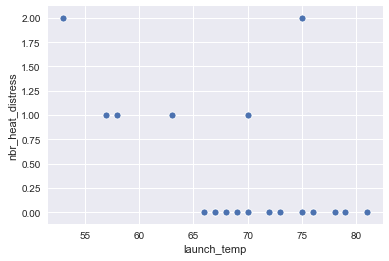

In [40]:
sns.scatterplot(x=raw_df['launch_temp'],y=raw_df['nbr_heat_distress'])

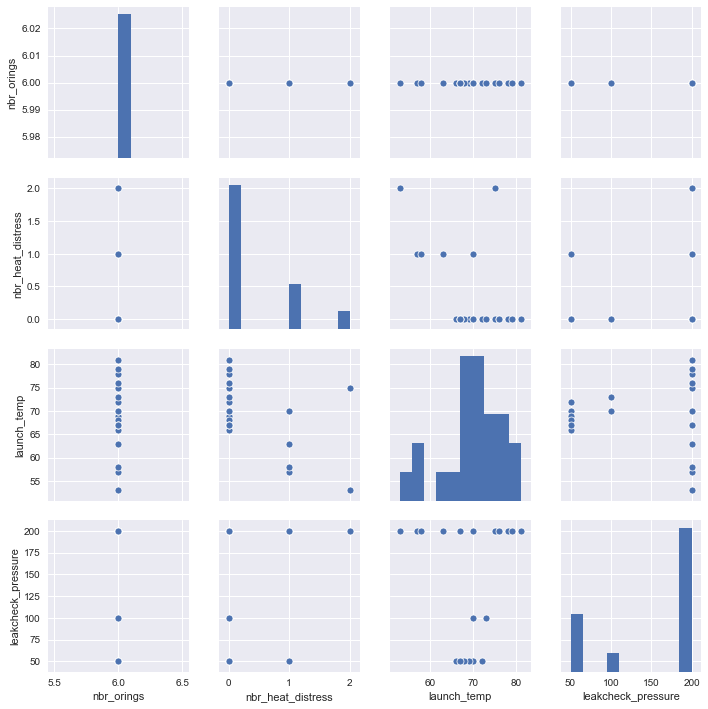

In [41]:
sns.pairplot(raw_df)

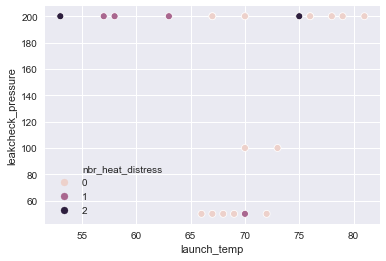

In [42]:
sns.scatterplot(x='launch_temp',y='leakcheck_pressure', hue='nbr_heat_distress', data=raw_df)

### Correlation

#### Pearson

- Number of o-rings isn't correlated with any of the other features. Which makes sence since it's the same number no mater what.
- The number of o-rings experiencing heat distress has a negative 0.51 correlation with the launch temperature
- Number of o-rings experiencing heat distress has a 0.28 correlation with leak check pressure. We would expect a low correlation for this since we would expect them to conduct multiple pressure checks at each temperature.
- Launch temp and leak check pressure have almost no correlation at 0.03.

#### Spearman
- Downgrades the correlation between nbr_heat_distress and launch_temp as well as nbr_heat_distress and leakcheck_pressure.
- Upgrades the correlation between launch_temp and leakcheck_pressure.

In [47]:
raw_df.corr()

,nbr_orings,nbr_heat_distress,launch_temp,leakcheck_pressure
nbr_orings,NaN,NaN,NaN,NaN
nbr_heat_distress,NaN,1.000000,-0.511126,0.284666
launch_temp,NaN,-0.511126,1.000000,0.039818
leakcheck_pressure,NaN,0.284666,0.039818,1.000000


In [63]:
raw_df.corr(method='spearman')

,nbr_orings,nbr_heat_distress,launch_temp,leakcheck_pressure
nbr_orings,NaN,NaN,NaN,NaN
nbr_heat_distress,NaN,1.000000,-0.429473,0.277556
launch_temp,NaN,-0.429473,1.000000,0.154133
leakcheck_pressure,NaN,0.277556,0.154133,1.000000


# Prepare data

- No missing values
- Dropped 'nbr_orings' as the value is the same for all observations
- Added failure rate feature
- Scale and normalize values

In [54]:
raw_df.columns

Index(['nbr_orings', 'nbr_heat_distress', 'launch_temp', 'leakcheck_pressure'], dtype='object')

In [49]:
def preprocess_data(df, scaler=StandardScaler()):
    columns = df.columns.tolist()
    index = df.index.tolist()
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df, columns=columns, index=index)
    return scaler, df

In [68]:
processed_df = raw_df.copy()
processed_df['failure_rate'] = processed_df['nbr_heat_distress'] / processed_df['nbr_orings']
processed_df.drop(['nbr_orings', 'nbr_heat_distress'], axis=1, inplace=True)

scaler, processed_df = preprocess_data(processed_df)

target = raw_df['nbr_heat_distress'].copy()

processed_df.head()

,launch_temp,leakcheck_pressure,failure_rate
1,-0.516551,-1.531343,-0.609557
2,0.062994,-1.531343,0.948200
3,-0.081892,-1.531343,-0.609557
4,-0.226779,-1.531343,-0.609557
5,-0.371665,-1.531343,-0.609557


# Explore models

In [73]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean", scores.mean())
    print("Standard deviation:", scores.std())

In [77]:
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, processed_df, target, scoring='neg_mean_squared_error', cv=5)
lin_rsme_scores = np.sqrt(-lin_scores)
display_scores(lin_rsme_scores)

Scores: [2.80866677e-16 2.17841488e-16 3.60608915e-16 4.28192166e-16
 1.68830575e-16]
Mean 2.912679643399105e-16
Standard deviation: 9.385835373140523e-17


In [78]:
tree_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(tree_reg, processed_df, target, scoring='neg_mean_squared_error', cv=5)
tree_rsme_scores = np.sqrt(-tree_scores)
display_scores(tree_rsme_scores)

Scores: [0.  0.  0.  0.  0.5]
Mean 0.1
Standard deviation: 0.2


In [79]:
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, processed_df, target, scoring='neg_mean_squared_error', cv=5)
forest_rsme_scores = np.sqrt(-forest_scores)
display_scores(forest_rsme_scores)

Scores: [0.04472136 0.06324555 0.27202941 0.         0.45276926]
Mean 0.16655311596698863
Standard deviation: 0.17105572063420396


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

In [95]:
models = [('LR', LinearRegression()), ('Tree', DecisionTreeRegressor()), ('Forest', RandomForestRegressor())]
results = []
names = []

for name, model in models:
    cv_results=cross_val_score(model, processed_df, target, cv=5, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    print("Model:", name)
    display_scores(cv_results)
    print('\n')

Model: LR
Scores: [-7.88860905e-32 -4.74549138e-32 -1.30038790e-31 -1.83348531e-31
 -2.85037632e-32]
Mean -9.364641761588495e-32
Standard deviation: 5.650833841926954e-32


Model: Tree
Scores: [-0. -0. -0. -0. -0.]
Mean 0.0
Standard deviation: 0.0


Model: Forest
Scores: [-0.008  -0.     -0.074  -0.     -0.1625]
Mean -0.04890000000000001
Standard deviation: 0.06323005614421043




//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

In [89]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']